In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [2]:
df = pd.read_csv(r'C:\Users\raclo\Documents\Bootcamp\Project 3\fdf_gdf.csv', low_memory=False, sep=",")

In [3]:
# Convert categorical columns to category type for memory efficiency
df["rideable_type"] = df["rideable_type"].astype("category")
df["start_station_name"] = df["start_station_name"].astype("category")
df["end_station_name"] = df["end_station_name"].astype("category")
df["member_casual"] = df["member_casual"].astype("category")
df["day_of_week"] = df["day_of_week"].astype("category")
df["holiday"] = df["holiday"].astype("category")

# Convert started_at and ended_at to datetime for memory efficiency
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df["holiday"] = df["holiday"].astype("category")

df['month'] = df['month'].astype('int32')

df["ride_duration"] = pd.to_timedelta(df["ride_duration"])

In [4]:
df_w7 = df[df['start_ward'] == 7]

In [5]:
zero_rows = (df_w7['start_station_id'] == 0).sum()
print(f"Number of rows with start_station_id = 0: {zero_rows}")

Number of rows with start_station_id = 0: 549


In [6]:
# Remove the rows where start_station_id == 0
df_w2 = df_w7[df_w7['start_station_id'] != 0]

In [7]:
# Manual encoding
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Copy DataFrame to avoid modifying original
df_encoded = df_w7.copy()

# Convert categorical columns to string (avoids mixed-type errors)
df_encoded[['day_of_week', 'holiday', 'is_weekend', 'season']] = df_encoded[['day_of_week', 'holiday', 'is_weekend', 'season']].astype(str)

### 1️⃣ Manually Encode 'holiday' and 'is_weekend' ###
df_encoded['holiday'] = df_encoded['holiday'].map({'Yes': 0, 'No': 1})
df_encoded['is_weekend'] = df_encoded['is_weekend'].map({'Yes': 0, 'No': 1})

### 2️⃣ Label Encode 'day_of_week' ###
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_encoded['day_of_week'] = df_encoded['day_of_week'].map(day_mapping)

### 3️⃣ Label Encode 'season' ###
season_mapping = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}
df_encoded['season'] = df_encoded['season'].map(season_mapping)

# ✅ Final DataFrame Preview
print(df_encoded.head())


     ride_id  rideable_type          started_at            ended_at  \
161  9326782  electric_bike 2023-09-14 18:09:35 2023-09-14 18:22:45   
169  9367599   classic_bike 2023-09-16 23:40:41 2023-09-16 23:44:18   
378  7533529   classic_bike 2023-05-17 07:24:51 2023-05-17 07:37:24   
410  8104181   classic_bike 2023-06-25 14:25:35 2023-06-25 14:28:06   
433  6243628  electric_bike 2023-01-03 13:57:18 2023-01-03 14:02:11   

            start_station_name  start_station_id  \
161  15th & East Capitol St NE           31630.0   
169        Rosedale Rec Center           31658.0   
378  19th & East Capitol St SE           31601.0   
410  15th & East Capitol St NE           31630.0   
433        Rosedale Rec Center           31658.0   

                                      end_station_name  end_station_id  \
161  Eastern Market Metro / Pennsylvania Ave & 8th ...         31613.0   
169                             Oklahoma Ave & D St NE         31712.0   
378                  Anacostia Roller 

In [8]:
df_numeric = df_encoded.select_dtypes(include=['float', 'int64']).dropna().copy()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11069 entries, 161 to 839718
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ride_id            11069 non-null  int64  
 1   start_station_id   11069 non-null  float64
 2   end_station_id     11069 non-null  float64
 3   start_lat          11069 non-null  float64
 4   start_lng          11069 non-null  float64
 5   end_lat            11069 non-null  float64
 6   end_lng            11069 non-null  float64
 7   distance           11069 non-null  float64
 8   year               11069 non-null  int64  
 9   season             11069 non-null  int64  
 10  day_of_week        11069 non-null  int64  
 11  holiday            11069 non-null  int64  
 12  is_weekend         11069 non-null  int64  
 13  start_ward         11069 non-null  int64  
 14  end_ward           11069 non-null  int64  
 15  ride_duration_min  11069 non-null  float64
dtypes: float64(8), int64(8)


In [9]:
# Convert datetime columns (started_at and ended_at) to datetime64 format.
import pandas as pd

# Ensure datetime format
df_encoded['started_at'] = pd.to_datetime(df_encoded['started_at'])
df_encoded['ended_at'] = pd.to_datetime(df_encoded['ended_at'])

# Extract hours
df_encoded['start_hour'] = df_encoded['started_at'].dt.hour

In [10]:
# Ensure the 'start_hour' column exists in the DataFrame
if 'start_hour' not in df_encoded.columns:
    # Extract the hour from the 'started_at' column
    df_encoded['start_hour'] = df_encoded['started_at'].dt.hour

# Ensure all selected columns exist in the DataFrame
required_columns = ["end_ward",
                    "started_at",
                    "start_hour",
                    'day_of_week',
                    'month',
                    'holiday',
                    'is_weekend',
                    'season'
                    ]

missing_columns = [col for col in required_columns if col not in df_encoded.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing in the DataFrame: {missing_columns}")

# Select features to predict bike rides
df_select = df_encoded[required_columns]

In [11]:
# Create a copy of df_select
df_select = df_select.copy()

In [12]:
# Ensure the 'date' column exists in df_select
df_select['date'] = df_select['started_at'].dt.date

# Aggregate the data by date
df_daily = df_select.groupby('date', as_index=False).agg(
    ride_count=('started_at', 'count'),
    # start_ward=('start_ward', 'first'),  
    end_ward=('end_ward', 'first'),
    month=('month', 'first'),
    day_of_week=('day_of_week', 'first'),
    holiday=('holiday', 'max'),  # If any ride that day was on a holiday, keep 1
    is_weekend=('is_weekend', 'max'),  # If any ride was on a weekend, keep 1
    season=('season', 'first')  
)

print(df_daily)

           date  ride_count  end_ward  month  day_of_week  holiday  \
0    2023-01-01          21         6      1            6        0   
1    2023-01-02          14         6      1            0        0   
2    2023-01-03          19         6      1            1        1   
3    2023-01-04          28         7      1            2        1   
4    2023-01-05          25         6      1            3        1   
..          ...         ...       ...    ...          ...      ...   
360  2023-12-27          10         7     12            2        1   
361  2023-12-28          24         6     12            3        1   
362  2023-12-29          18         6     12            4        1   
363  2023-12-30          14         6     12            5        1   
364  2023-12-31          18         6     12            6        1   

     is_weekend  season  
0             0       3  
1             1       3  
2             1       3  
3             1       3  
4             1       3  
.. 

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
multivariate = df_daily.drop('ride_count',axis='columns')
ride_count = df_daily["ride_count"]

print(multivariate.shape)
print(ride_count.shape)

(365, 7)
(365,)


In [15]:
df_daily.dtypes

date           object
ride_count      int64
end_ward        int64
month           int32
day_of_week     int64
holiday         int64
is_weekend      int64
season          int64
dtype: object

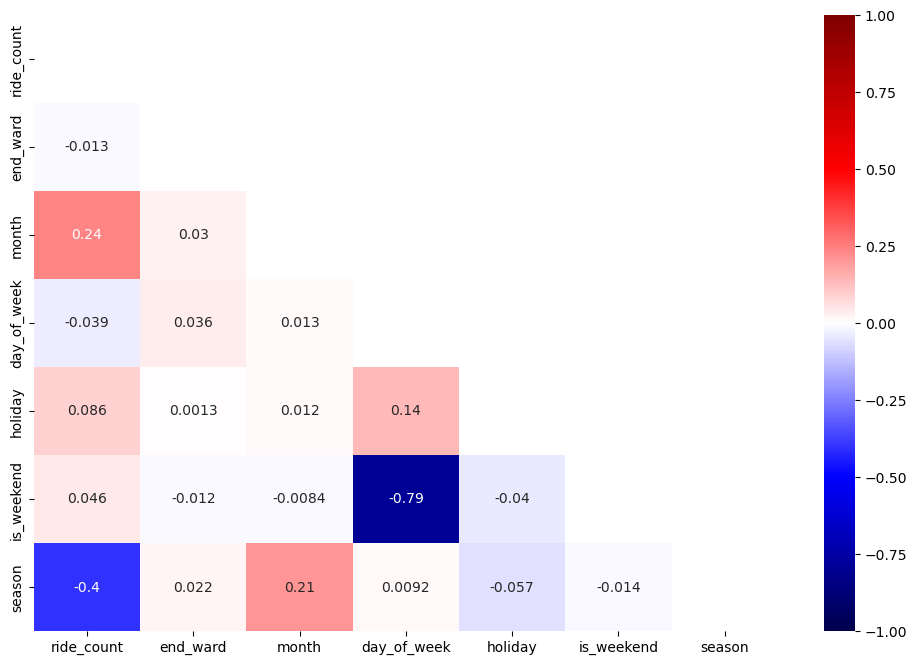

In [16]:
import seaborn as sns

plt.figure(figsize=(12,8))

# Select only numeric columns for correlation
numeric_df = df_daily.select_dtypes(include=['float64', 'int64', 'int32'])
corr = numeric_df.corr()

# Create a mask for the upper triangle
matrix = np.triu(corr)

# Plot the heatmap
sns.heatmap(corr, annot=True, mask=matrix, vmin=-1, vmax=1, cmap='seismic')
plt.show()

In [17]:
hdf = pd.read_csv(r'C:\Users\raclo\Documents\Bootcamp\Project 3\cbs_hourly_modified.csv', sep=",")

In [18]:
df_daily['date'] = pd.to_datetime(df_daily['date'])
hdf['date'] = pd.to_datetime(hdf['date'])

In [19]:
# Ensure the 'date' column is a datetime
hdf['date'] = pd.to_datetime(hdf['date'])

# Aggregate hdf to daily values by taking the mean for the desired columns
hdf_daily = hdf.groupby('date', as_index=False).agg(
    relativehumidity=('relativehumidity', 'mean'),
    temperature=('temperature', 'mean'),
    windspeed=('windspeed', 'mean')
)

In [20]:
# Ensure 'date' in df_daily is also a datetime
df_daily['date'] = pd.to_datetime(df_daily['date'])

# Merge the daily aggregated dataframes on 'date'
df_merged = df_daily.merge(hdf_daily, on='date', how='left')
display(df_merged)

,date,ride_count,end_ward,month,day_of_week,holiday,is_weekend,season,relativehumidity,temperature,windspeed
0,2023-01-01,21,6,1,6,0,0,3,83.375000,10.458333,9.466667
1,2023-01-02,14,6,1,0,0,1,3,83.375000,10.745833,7.525000
2,2023-01-03,19,6,1,1,1,1,3,89.541667,14.229167,13.316667
3,2023-01-04,28,7,1,2,1,1,3,91.250000,15.962500,11.308333
4,2023-01-05,25,6,1,3,1,1,3,83.500000,12.558333,7.295833
...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,10,7,12,2,1,1,3,52.000000,-4.350000,5.241667
361,2023-12-28,24,6,12,3,1,1,3,53.583333,-2.487500,7.650000
362,2023-12-29,18,6,12,4,1,1,3,57.791667,-3.904167,3.966667
363,2023-12-30,14,6,12,5,1,0,3,58.083333,-2.900000,7.933333


In [21]:
# Drop unnecessary columns
df_merged = df_merged.drop(columns=['date', 'month', 'day_of_week'])

In [22]:
df_merged.rename(columns={'relativehumidity': 'humidity'}, inplace=True)

# ML

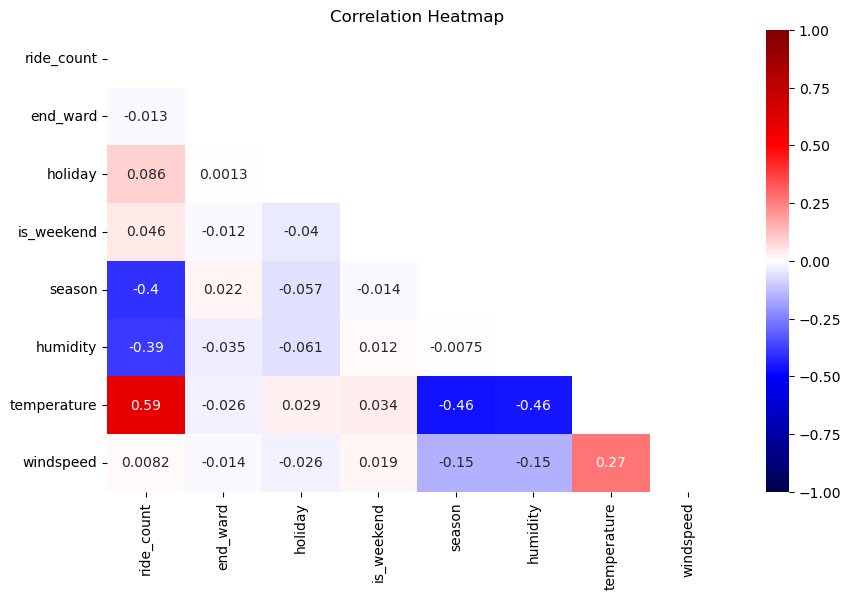

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df_merged.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, cmap='seismic')
plt.title("Correlation Heatmap")
plt.show()


In [24]:
# Convert 'season' to Categorical
df_merged['season'] = df_merged['season'].astype('category')

## 7 features: 'end_ward', 'holiday', 'is_weekend', 'season', 'humidity', 'temperature', 'windspeed'

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 🚀 Feature Selection 1: Use All Features
X1 = df_merged.drop(columns=['ride_count'])  
X1 = pd.get_dummies(X1, columns=['season'], drop_first=True)  # One-hot encode 'season'
y = df_merged['ride_count']

# 🎯 Split data for Feature Selection 1
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# ✅ Train & Evaluate Model 1 (Linear)
lin_reg1 = LinearRegression()
lin_reg1.fit(X1_train, y_train)
y_pred_lin1 = lin_reg1.predict(X1_test)

r2_lin1 = lin_reg1.score(X1_test, y_test)
mae_lin1 = mean_absolute_error(y_test, y_pred_lin1)
mse_lin1 = mean_squared_error(y_test, y_pred_lin1)
rmse_lin1 = np.sqrt(mse_lin1)

print(f"📊 Feature Set 1 (All Features) - Linear Regression:")
print(f"R²: {r2_lin1}")
print(f"MAE: {mae_lin1}")
print(f"MSE: {mse_lin1}")
print(f"RMSE: {rmse_lin1}")

# ✅ Train & Evaluate Model 1 (Polynomial)
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

poly1 = PolynomialFeatures(degree=2)
X1_poly_train = poly1.fit_transform(X1_train_scaled)
X1_poly_test = poly1.transform(X1_test_scaled)

poly_reg1 = LinearRegression()
poly_reg1.fit(X1_poly_train, y_train)
y_pred_poly1 = poly_reg1.predict(X1_poly_test)

r2_poly1 = poly_reg1.score(X1_poly_test, y_test)
mae_poly1 = mean_absolute_error(y_test, y_pred_poly1)
mse_poly1 = mean_squared_error(y_test, y_pred_poly1)
rmse_poly1 = np.sqrt(mse_poly1)

print(f"\n📊 Feature Set 1 (All Features) - Polynomial Regression:")
print(f"R²: {r2_poly1}")
print(f"MAE: {mae_poly1}")
print(f"MSE: {mse_poly1}")
print(f"RMSE: {rmse_poly1}")

📊 Feature Set 1 (All Features) - Linear Regression:
R²: 0.37461643700120384
MAE: 7.3359116979596
MSE: 91.20859573971032
RMSE: 9.550319143343343

📊 Feature Set 1 (All Features) - Polynomial Regression:
R²: -0.5376538698736113
MAE: 11.107020547945206
MSE: 224.25797303082192
RMSE: 14.975245341256413


## 4 features: Drop 'end_ward', 'holiday', 'is_weekend'

In [26]:
# 🚀 Feature Selection 2: Drop end_ward, holiday, is_weekend
columns_to_drop = ['end_ward', 'holiday', 'is_weekend']
X2 = df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns] + ['ride_count'])
X2 = pd.get_dummies(X2, columns=['season'], drop_first=True)  # One-hot encode 'season'

# 🎯 Split data for Feature Selection 2
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# ✅ Train & Evaluate Model 2 (Linear)
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train, y_train)
y_pred_lin2 = lin_reg2.predict(X2_test)

r2_lin2 = lin_reg2.score(X2_test, y_test)
mae_lin2 = mean_absolute_error(y_test, y_pred_lin2)
mse_lin2 = mean_squared_error(y_test, y_pred_lin2)
rmse_lin2 = np.sqrt(mse_lin2)

print(f"\n📊 Feature Set 2 (Dropped Features) - Linear Regression:")
print(f"R²: {r2_lin2}")
print(f"MAE: {mae_lin2}")
print(f"MSE: {mse_lin2}")
print(f"RMSE: {rmse_lin2}")

# ✅ Train & Evaluate Model 2 (Polynomial)
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

poly2 = PolynomialFeatures(degree=2)
X2_poly_train = poly2.fit_transform(X2_train_scaled)
X2_poly_test = poly2.transform(X2_test_scaled)

poly_reg2 = LinearRegression()
poly_reg2.fit(X2_poly_train, y_train)
y_pred_poly2 = poly_reg2.predict(X2_poly_test)

r2_poly2 = poly_reg2.score(X2_poly_test, y_test)
mae_poly2 = mean_absolute_error(y_test, y_pred_poly2)
mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
rmse_poly2 = np.sqrt(mse_poly2)

print(f"\n📊 Feature Set 2 (Dropped Features) - Polynomial Regression:")
print(f"R²: {r2_poly2}")
print(f"MAE: {mae_poly2}")
print(f"MSE: {mse_poly2}")
print(f"RMSE: {rmse_poly2}")



📊 Feature Set 2 (Dropped Features) - Linear Regression:
R²: 0.39025026612849667
MAE: 7.270873897245995
MSE: 88.92849168021539
RMSE: 9.43019043711289

📊 Feature Set 2 (Dropped Features) - Polynomial Regression:
R²: 0.38798994599227365
MAE: 7.56639621682363
MSE: 89.25814637174345
RMSE: 9.447652955720985


## 4 features: Drop 'end_ward', 'holiday', 'is_weekend'

In [27]:
# 🚀 Feature Selection 2: Drop end_ward, holiday, is_weekend
columns_to_drop = ['end_ward', 'holiday', 'is_weekend']
X2 = df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns] + ['ride_count'])
X2 = pd.get_dummies(X2, columns=['season'], drop_first=True)  # One-hot encode 'season'

# 🎯 Split data for Feature Selection 2
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# ✅ Train & Evaluate Model 2 (Linear)
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train, y_train)
y_pred_lin2 = lin_reg2.predict(X2_test)

r2_lin2 = lin_reg2.score(X2_test, y_test)
mae_lin2 = mean_absolute_error(y_test, y_pred_lin2)
mse_lin2 = mean_squared_error(y_test, y_pred_lin2)
rmse_lin2 = np.sqrt(mse_lin2)

print(f"\n📊 Feature Set 2 (Dropped Features) - Linear Regression:")
print(f"R²: {r2_lin2}")
print(f"MAE: {mae_lin2}")
print(f"MSE: {mse_lin2}")
print(f"RMSE: {rmse_lin2}")

# ✅ Train & Evaluate Model 2 (Polynomial)
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

poly2 = PolynomialFeatures(degree=2)
X2_poly_train = poly2.fit_transform(X2_train_scaled)
X2_poly_test = poly2.transform(X2_test_scaled)

poly_reg2 = LinearRegression()
poly_reg2.fit(X2_poly_train, y_train)
y_pred_poly2 = poly_reg2.predict(X2_poly_test)

r2_poly2 = poly_reg2.score(X2_poly_test, y_test)
mae_poly2 = mean_absolute_error(y_test, y_pred_poly2)
mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
rmse_poly2 = np.sqrt(mse_poly2)

print(f"\n📊 Feature Set 2 (Dropped Features) - Polynomial Regression:")
print(f"R²: {r2_poly2}")
print(f"MAE: {mae_poly2}")
print(f"MSE: {mse_poly2}")
print(f"RMSE: {rmse_poly2}")


📊 Feature Set 2 (Dropped Features) - Linear Regression:
R²: 0.39025026612849667
MAE: 7.270873897245995
MSE: 88.92849168021539
RMSE: 9.43019043711289

📊 Feature Set 2 (Dropped Features) - Polynomial Regression:
R²: 0.38798994599227365
MAE: 7.56639621682363
MSE: 89.25814637174345
RMSE: 9.447652955720985


## 3 features: drop windspeed

In [31]:
# 🚀 Feature Selection 3: Drop windspeed
X3 = df_merged.drop(columns=['ride_count', 'windspeed'])
X3 = pd.get_dummies(X3, columns=['season'], drop_first=True)  # One-hot encode 'season'

# 🎯 Split data for Feature Selection 3
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# ✅ Train & Evaluate Model 3 (Linear)
lin_reg3 = LinearRegression()
lin_reg3.fit(X3_train, y_train)
y_pred_lin3 = lin_reg3.predict(X3_test)

r2_lin3 = lin_reg3.score(X3_test, y_test)
mae_lin3 = mean_absolute_error(y_test, y_pred_lin3)
mse_lin3 = mean_squared_error(y_test, y_pred_lin3)
rmse_lin3 = np.sqrt(mse_lin3)

print(f"\n📊 Feature Set 3 (Dropped Windspeed) - Linear Regression:")
print(f"R²: {r2_lin3}")
print(f"MAE: {mae_lin3}")
print(f"MSE: {mse_lin3}")
print(f"RMSE: {rmse_lin3}")

# ✅ Train & Evaluate Model 3 (Polynomial)
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_test_scaled = scaler3.transform(X3_test)

poly3 = PolynomialFeatures(degree=2)
X3_poly_train = poly3.fit_transform(X3_train_scaled)
X3_poly_test = poly3.transform(X3_test_scaled)

poly_reg3 = LinearRegression()
poly_reg3.fit(X3_poly_train, y_train)
y_pred_poly3 = poly_reg3.predict(X3_poly_test)

r2_poly3 = poly_reg3.score(X3_poly_test, y_test)
mae_poly3 = mean_absolute_error(y_test, y_pred_poly3)
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
rmse_poly3 = np.sqrt(mse_poly3)

print(f"\n📊 Feature Set 3 (Dropped Windspeed) - Polynomial Regression:")
print(f"R²: {r2_poly3}")
print(f"MAE: {mae_poly3}")
print(f"MSE: {mse_poly3}")
print(f"RMSE: {rmse_poly3}")


📊 Feature Set 3 (Dropped Windspeed) - Linear Regression:
R²: 0.3654854638264673
MAE: 7.480845310207751
MSE: 92.54029566001392
RMSE: 9.619786674350628

📊 Feature Set 3 (Dropped Windspeed) - Polynomial Regression:
R²: -6.514317227201611
MAE: 20.347602739726028
MSE: 1095.919948630137
RMSE: 33.104681672387926


In [32]:
import pandas as pd

# Create a summary table
results = {
    "Feature Selection": ["Feature Set 1 (All Features)", "Feature Set 1 (All Features)", "Feature Set 1 (All Features)",
                          "Feature Set 2 (Dropped Features)", "Feature Set 2 (Dropped Features)", "Feature Set 2 (Dropped Features)",
                          "Feature Set 3 (Dropped Windspeed)", "Feature Set 3 (Dropped Windspeed)", "Feature Set 3 (Dropped Windspeed)"],
    "Model": ["Linear Regression", "Polynomial Regression", "Polynomial Regression",
              "Linear Regression", "Polynomial Regression", "Polynomial Regression",
              "Linear Regression", "Polynomial Regression", "Polynomial Regression"],
    "R²": [r2_lin1, r2_poly1, r2_poly2, r2_lin2, r2_poly2, r2_poly3, r2_lin3, r2_poly3, r2_poly3],
    "MAE": [mae_lin1, mae_poly1, mae_poly2, mae_lin2, mae_poly2, mae_poly3, mae_lin3, mae_poly3, mae_poly3],
    "MSE": [mse_lin1, mse_poly1, mse_poly2, mse_lin2, mse_poly2, mse_poly3, mse_lin3, mse_poly3, mse_poly3],
    "RMSE": [rmse_lin1, rmse_poly1, rmse_poly2, rmse_lin2, rmse_poly2, rmse_poly3, rmse_lin3, rmse_poly3, rmse_poly3]
}

summary_table = pd.DataFrame(results).drop_duplicates(subset=["Feature Selection", "Model"])
print(summary_table)

                   Feature Selection                  Model        R²  \
0       Feature Set 1 (All Features)      Linear Regression  0.374616   
1       Feature Set 1 (All Features)  Polynomial Regression -0.537654   
3   Feature Set 2 (Dropped Features)      Linear Regression  0.390250   
4   Feature Set 2 (Dropped Features)  Polynomial Regression  0.387990   
6  Feature Set 3 (Dropped Windspeed)      Linear Regression  0.365485   
7  Feature Set 3 (Dropped Windspeed)  Polynomial Regression -6.514317   

         MAE          MSE       RMSE  
0   7.335912    91.208596   9.550319  
1  11.107021   224.257973  14.975245  
3   7.270874    88.928492   9.430190  
4   7.566396    89.258146   9.447653  
6   7.480845    92.540296   9.619787  
7  20.347603  1095.919949  33.104682  


In [34]:
# Round the values in the summary table to two decimal places
summary_table = summary_table.round({'R²': 2, 'MAE': 2, 'MSE': 2, 'RMSE': 2})
print(summary_table)


                   Feature Selection                  Model    R²    MAE  \
0       Feature Set 1 (All Features)      Linear Regression  0.37   7.34   
1       Feature Set 1 (All Features)  Polynomial Regression -0.54  11.11   
3   Feature Set 2 (Dropped Features)      Linear Regression  0.39   7.27   
4   Feature Set 2 (Dropped Features)  Polynomial Regression  0.39   7.57   
6  Feature Set 3 (Dropped Windspeed)      Linear Regression  0.37   7.48   
7  Feature Set 3 (Dropped Windspeed)  Polynomial Regression -6.51  20.35   

       MSE   RMSE  
0    91.21   9.55  
1   224.26  14.98  
3    88.93   9.43  
4    89.26   9.45  
6    92.54   9.62  
7  1095.92  33.10  


In [35]:
summary_table

,Feature Selection,Model,R²,MAE,MSE,RMSE
0,Feature Set 1 (All Features),Linear Regression,0.37,7.34,91.21,9.55
1,Feature Set 1 (All Features),Polynomial Regression,-0.54,11.11,224.26,14.98
3,Feature Set 2 (Dropped Features),Linear Regression,0.39,7.27,88.93,9.43
4,Feature Set 2 (Dropped Features),Polynomial Regression,0.39,7.57,89.26,9.45
6,Feature Set 3 (Dropped Windspeed),Linear Regression,0.37,7.48,92.54,9.62
7,Feature Set 3 (Dropped Windspeed),Polynomial Regression,-6.51,20.35,1095.92,33.10
